In [50]:
# Import all necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder ,PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("Pokemon (1).csv")


In [88]:
df['CAS'] = df['Attack'] + df['Sp. Atk'] + (df['Speed'] * 0.5)

In [7]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,CAS
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,136.5
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,172.0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,222.0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,262.0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,144.5


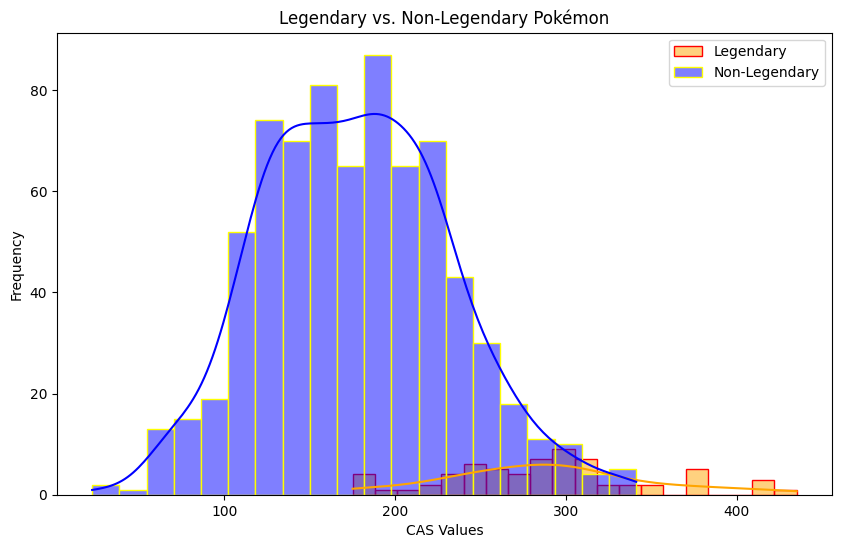

In [93]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df["Legendary"] == True]["CAS"], bins=20, color='orange', label="Legendary", edgecolor='red', kde=True)
sns.histplot(df[df["Legendary"] == False]["CAS"], bins=20, color="blue", label="Non-Legendary", edgecolor="yellow", kde=True)
plt.title("Legendary vs. Non-Legendary Pokémon")
plt.xlabel("CAS Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       147
           1       0.67      0.62      0.64        13

    accuracy                           0.94       160
   macro avg       0.82      0.79      0.80       160
weighted avg       0.94      0.94      0.94       160


Accuracy: 0.9437
F1 Score: 0.6400


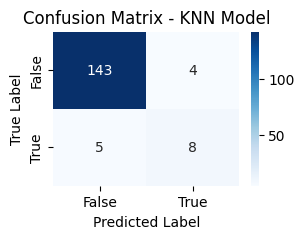

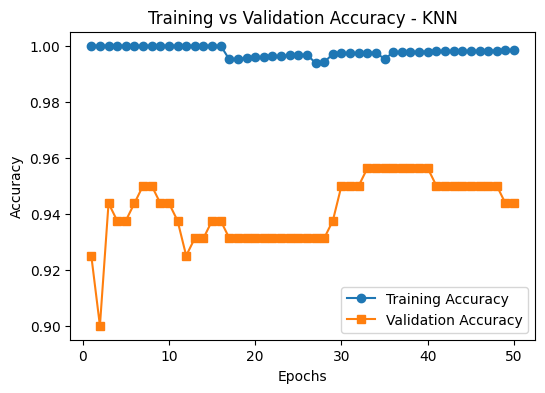

In [78]:
# Select features and target
X = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']]
y = df['Legendary']

# Encode target labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into train and test sets (using stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN model with tuned hyperparameters
model = KNeighborsClassifier(n_neighbors=1)
# Train the model
model.fit(X_train, y_train)

# Shuffle before prediction
X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test, random_state=42)

# Predict
y_pred = model.predict(X_test_shuffled)

# Evaluate
acc = accuracy_score(y_test_shuffled, y_pred)
f1 = f1_score(y_test_shuffled, y_pred)
print("\nClassification Report:\n", classification_report(y_test_shuffled, y_pred))
print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_shuffled, y_pred)

# Plot confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN Model')
plt.show()

# Track training and validation accuracy
train_acc = []
val_acc = []
steps = 50
chunk_size = len(X_train) // steps

for i in range(1, steps + 1):
    model.fit(X_train[:i * chunk_size], y_train[:i * chunk_size])
    train_acc.append(model.score(X_train[:i * chunk_size], y_train[:i * chunk_size]))
    val_acc.append(model.score(X_test, y_test))

# Plot training vs validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, steps + 1), train_acc, label='Training Accuracy', marker='o')
plt.plot(range(1, steps + 1), val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy - KNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


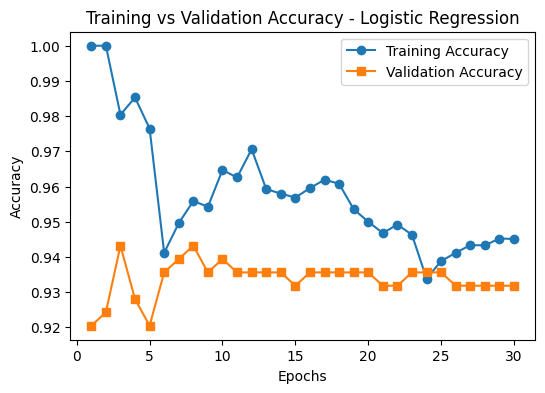

Final Accuracy: 0.9318
Final F1 Score: 0.7317


In [79]:
# Assuming 'df' is your dataframe
df = pd.read_csv("Pokemon (1).csv")

# Select features and target
X = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']]
y = df['Legendary']

# Encode the target labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into train and test sets (using stratify for balance)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42, stratify=y_encoded)

# Scale the data for better performance with most models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Shuffle the training data before fitting
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Define Logistic Regression model (supports incremental fitting with solver='saga')
model = LogisticRegression(solver='saga', max_iter=1000, random_state=42)

# Track training and validation accuracy
train_acc = []
val_acc = []

steps = 30
chunk_size = len(X_train) // steps

# Incremental training and evaluation
for i in range(1, steps + 1):
    # Train on an incremental subset of the training data
    model.fit(X_train[:i * chunk_size], y_train[:i * chunk_size])
    
    # Evaluate accuracy on both training and validation data
    train_accuracy = accuracy_score(y_train[:i * chunk_size], model.predict(X_train[:i * chunk_size]))
    val_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Append the accuracy to lists
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

# Plot training vs validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, steps + 1), train_acc, label='Training Accuracy', marker='o')
plt.plot(range(1, steps + 1), val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy - Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final predictions and evaluation on the test set
y_pred = model.predict(X_test)

# Compute Accuracy and F1 score
final_accuracy = accuracy_score(y_test, y_pred)
final_f1_score = f1_score(y_test, y_pred, average='macro')

# Output final results
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final F1 Score: {final_f1_score:.4f}")




Final Model Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       147
           1       0.79      0.85      0.81        13

    accuracy                           0.97       160
   macro avg       0.89      0.91      0.90       160
weighted avg       0.97      0.97      0.97       160


Final Accuracy: 0.9688
Final F1 Score: 0.8148


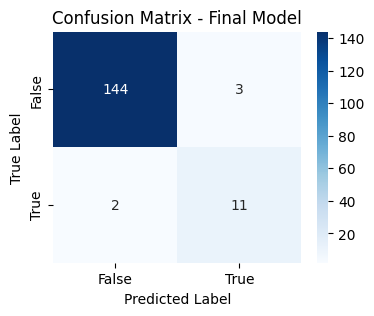

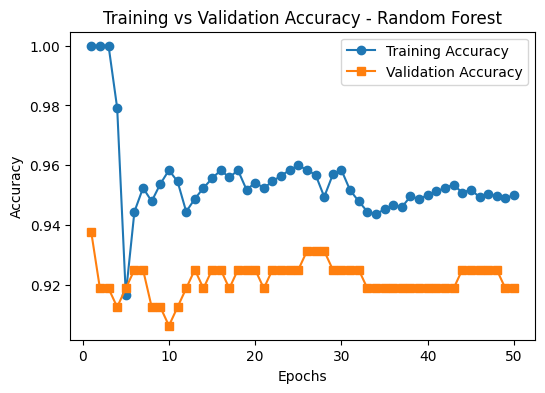

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("Pokemon (1).csv")

# Select features and target
X = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']]
y = df['Legendary']

# Encode target labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into train and test sets (using stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Best Parameters as obtained
best_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt'
}

# Train final model with best parameters
final_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    class_weight='balanced',
    random_state=42
)

final_model.fit(X_train, y_train)

# Shuffle before final prediction
X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test, random_state=42)

# Predict with final model
y_pred = final_model.predict(X_test_shuffled)

# Evaluate final model
acc = accuracy_score(y_test_shuffled, y_pred)
f1 = f1_score(y_test_shuffled, y_pred)
print("\nFinal Model Classification Report:\n", classification_report(y_test_shuffled, y_pred))
print(f"\nFinal Accuracy: {acc:.4f}")
print(f"Final F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test_shuffled, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Final Model')
plt.show()

# Track training and validation accuracy
train_acc = []
val_acc = []

steps = 50
chunk_size = len(X_train) // steps

# Incremental training and evaluation
for i in range(1, steps + 1):
    # Train on an incremental subset of the training data
    model.fit(X_train[:i * chunk_size], y_train[:i * chunk_size])
    
    # Evaluate accuracy on both training and validation data
    train_accuracy = accuracy_score(y_train[:i * chunk_size], model.predict(X_train[:i * chunk_size]))
    val_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Append the accuracy to lists
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

# Plot training vs validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, steps + 1), train_acc, label='Training Accuracy', marker='o')
plt.plot(range(1, steps + 1), val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy - Random Forest')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       147
           1       0.75      0.92      0.83        13

    accuracy                           0.97       160
   macro avg       0.87      0.95      0.91       160
weighted avg       0.97      0.97      0.97       160


Accuracy: 0.9688
F1 Score: 0.8276


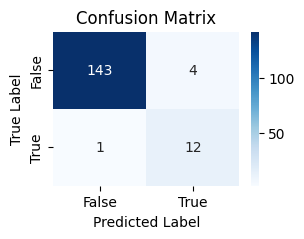

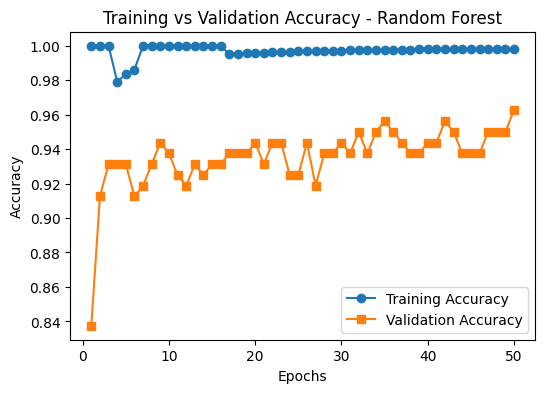

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

# Load the data
df = pd.read_csv("Pokemon (1).csv")

# Select features and target
X = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total']]
y = df['Legendary']

# Encode target
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into train and test sets (using stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost model with tuned hyperparameters
model = XGBClassifier(
    n_estimators=189,            # Number of boosting rounds
    max_depth=5,                 # Tree depth
    subsample=0.8,               # Fraction of samples used to train each tree
    alpha=0.1,                   # L1 regularization term
    scale_pos_weight=(y_encoded == 0).sum() / (y_encoded == 1).sum(),  # Handle class imbalance
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# **Shuffle before predicting**
X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test, random_state=42)

# Predictions
y_pred = model.predict(X_test_shuffled)

# Evaluate
acc = accuracy_score(y_test_shuffled, y_pred)
f1 = f1_score(y_test_shuffled, y_pred)
print("\nClassification Report:\n", classification_report(y_test_shuffled, y_pred))
print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_shuffled, y_pred)

# Plot confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Track training and validation accuracy
train_acc = []
val_acc = []

steps = 50
chunk_size = len(X_train) // steps

# Incremental training and evaluation
for i in range(1, steps + 1):
    # Train on an incremental subset of the training data
    model.fit(X_train[:i * chunk_size], y_train[:i * chunk_size])
    
    # Evaluate accuracy on both training and validation data
    train_accuracy = accuracy_score(y_train[:i * chunk_size], model.predict(X_train[:i * chunk_size]))
    val_accuracy = accuracy_score(y_test, model.predict(X_test))
    
    # Append the accuracy to lists
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

# Plot training vs validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, steps + 1), train_acc, label='Training Accuracy', marker='o')
plt.plot(range(1, steps + 1), val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy -XGBoost')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
